<a href="https://colab.research.google.com/github/Abhishek6968/S4-Main-Project/blob/main/Violence%20Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%matplotlib inline
import cv2
import os
import numpy as np
import keras
import matplotlib.pyplot as plt
# import download
from random import shuffle
from tensorflow.keras.applications import VGG16
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Activation
import sys
import h5py

In [5]:
keras.__version__


'2.15.0'

In [6]:
def print_progress(count, max_count):
    # Percentage completion.
    pct_complete = count / max_count

    # Status-message. Note the \r which means the line should
    # overwrite itself.
    msg = "\r- Progress: {0:.1%}".format(pct_complete)

    # Print it.
    sys.stdout.write(msg)
    sys.stdout.flush()

In [16]:
in_dir = "/content/drive/MyDrive/Dataset"

In [17]:
import sys

def is_module_imported(module_name):
    return module_name in sys.modules

# Usage example:
if is_module_imported('os'):
    print("The os module has been imported.")
else:
    print("The os module has not been imported.")



The os module has been imported.


In [18]:
# Frame size
img_size = 224

img_size_touple = (img_size, img_size)

# Number of channels (RGB)
num_channels = 3

# Flat frame size
img_size_flat = img_size * img_size * num_channels

# Number of classes for classification (Violence-No Violence)
num_classes = 2

# Number of files to train
_num_files_train = 1

# Number of frames per video
_images_per_file = 20

# Number of frames per training set
_num_images_train = _num_files_train * _images_per_file

# Video extension
video_exts = ".avi"

In [19]:
def get_frames(current_dir, file_name):

    in_file = os.path.join(current_dir, file_name)

    images = []

    vidcap = cv2.VideoCapture(in_file)

    success,image = vidcap.read()

    count = 0

    while count<_images_per_file:

        RGB_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        res = cv2.resize(RGB_img, dsize=(img_size, img_size),
                                 interpolation=cv2.INTER_CUBIC)

        images.append(res)

        success,image = vidcap.read()

        count += 1

    resul = np.array(images)

    resul = (resul / 255.).astype(np.float16)

    return resul

In [20]:
def label_video_names(in_dir):

    # list containing video names
    names = []
    # list containin video labels [1, 0] if it has violence and [0, 1] if not
    labels = []


    for current_dir, dir_names,file_names in os.walk(in_dir):

        for file_name in file_names:

            if file_name[0:2] == 'fi':
                labels.append([1,0])
                names.append(file_name)
            elif file_name[0:2] == 'no':
                labels.append([0,1])
                names.append(file_name)


    c = list(zip(names,labels))
    # Suffle the data (names and labels)
    shuffle(c)

    names, labels = zip(*c)

    return names, labels

In [21]:
# First get the names and labels of the whole videos
names, labels = label_video_names(in_dir)

In [22]:
names[12]

'fi110_xvid.avi'

In [23]:
frames = get_frames(in_dir, names[12])

In [24]:
visible_frame = (frames*255).astype('uint8')

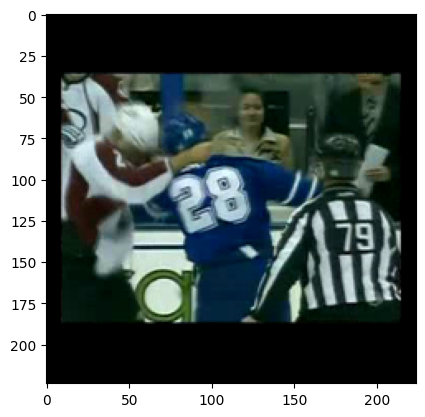

In [25]:
plt.imshow(visible_frame[15])

In [26]:
image_model = VGG16(include_top=True, weights='imagenet')

553467096/553467096 [==============================] - 8s 0us/step


In [27]:
image_model.summary()


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [28]:
# We will use the output of the layer prior to the final
# classification-layer which is named fc2. This is a fully-connected (or dense) layer.
transfer_layer = image_model.get_layer('fc2')

image_model_transfer = Model(inputs=image_model.input,
                             outputs=transfer_layer.output)

transfer_values_size = K.int_shape(transfer_layer.output)[1]


print("The input of the VGG16 net have dimensions:",K.int_shape(image_model.input)[1:3])

print("The output of the selecter layer of VGG16 net have dimensions: ", transfer_values_size)

The input of the VGG16 net have dimensions: (224, 224)
The output of the selecter layer of VGG16 net have dimensions:  4096


In [29]:
def get_transfer_values(current_dir, file_name):

    # Pre-allocate input-batch-array for images.
    shape = (_images_per_file,) + img_size_touple + (3,)

    image_batch = np.zeros(shape=shape, dtype=np.float16)

    image_batch = get_frames(current_dir, file_name)

    # Pre-allocate output-array for transfer-values.
    # Note that we use 16-bit floating-points to save memory.
    shape = (_images_per_file, transfer_values_size)
    transfer_values = np.zeros(shape=shape, dtype=np.float16)

    transfer_values = \
            image_model_transfer.predict(image_batch)

    return transfer_values

In [30]:
def proces_transfer(vid_names, in_dir, labels):

    count = 0

    tam = len(vid_names)

    # Pre-allocate input-batch-array for images.
    shape = (_images_per_file,) + img_size_touple + (3,)

    while count<tam:

        video_name = vid_names[count]

        image_batch = np.zeros(shape=shape, dtype=np.float16)

        image_batch = get_frames(in_dir, video_name)

         # Note that we use 16-bit floating-points to save memory.
        shape = (_images_per_file, transfer_values_size)
        transfer_values = np.zeros(shape=shape, dtype=np.float16)

        transfer_values = \
            image_model_transfer.predict(image_batch)

        labels1 = labels[count]

        aux = np.ones([20,2])

        labelss = labels1*aux

        yield transfer_values, labelss

        count+=1

In [31]:
def make_files(n_files):

    gen = proces_transfer(names_training, in_dir, labels_training)

    numer = 1

    # Read the first chunk to get the column dtypes
    chunk = next(gen)

    row_count = chunk[0].shape[0]
    row_count2 = chunk[1].shape[0]

    with h5py.File('prueba.h5', 'w') as f:

        # Initialize a resizable dataset to hold the output
        maxshape = (None,) + chunk[0].shape[1:]
        maxshape2 = (None,) + chunk[1].shape[1:]


        dset = f.create_dataset('data', shape=chunk[0].shape, maxshape=maxshape,
                                chunks=chunk[0].shape, dtype=chunk[0].dtype)

        dset2 = f.create_dataset('labels', shape=chunk[1].shape, maxshape=maxshape2,
                                 chunks=chunk[1].shape, dtype=chunk[1].dtype)

         # Write the first chunk of rows
        dset[:] = chunk[0]
        dset2[:] = chunk[1]

        for chunk in gen:

            if numer == n_files:

                break

            # Resize the dataset to accommodate the next chunk of rows
            dset.resize(row_count + chunk[0].shape[0], axis=0)
            dset2.resize(row_count2 + chunk[1].shape[0], axis=0)

            # Write the next chunk
            dset[row_count:] = chunk[0]
            dset2[row_count:] = chunk[1]

            # Increment the row count
            row_count += chunk[0].shape[0]
            row_count2 += chunk[1].shape[0]

            print_progress(numer, n_files)

            numer += 1

In [32]:
def make_files_test(n_files):

    gen = proces_transfer(names_test, in_dir, labels_test)

    numer = 1

    # Read the first chunk to get the column dtypes
    chunk = next(gen)

    row_count = chunk[0].shape[0]
    row_count2 = chunk[1].shape[0]

    with h5py.File('pruebavalidation.h5', 'w') as f:

        # Initialize a resizable dataset to hold the output
        maxshape = (None,) + chunk[0].shape[1:]
        maxshape2 = (None,) + chunk[1].shape[1:]


        dset = f.create_dataset('data', shape=chunk[0].shape, maxshape=maxshape,
                                chunks=chunk[0].shape, dtype=chunk[0].dtype)

        dset2 = f.create_dataset('labels', shape=chunk[1].shape, maxshape=maxshape2,
                                 chunks=chunk[1].shape, dtype=chunk[1].dtype)

         # Write the first chunk of rows
        dset[:] = chunk[0]
        dset2[:] = chunk[1]

        for chunk in gen:

            if numer == n_files:

                break

            # Resize the dataset to accommodate the next chunk of rows
            dset.resize(row_count + chunk[0].shape[0], axis=0)
            dset2.resize(row_count2 + chunk[1].shape[0], axis=0)

            # Write the next chunk
            dset[row_count:] = chunk[0]
            dset2[row_count:] = chunk[1]

            # Increment the row count
            row_count += chunk[0].shape[0]
            row_count2 += chunk[1].shape[0]

            print_progress(numer, n_files)

            numer += 1

In [33]:
training_set = int(len(names)*0.8)
test_set = int(len(names)*0.2)

names_training = names[0:training_set]
names_test = names[training_set:]

labels_training = labels[0:training_set]
labels_test = labels[training_set:]

In [34]:
make_files(training_set)

1/1 [==============================] - 13s 13s/step
- Progress: 99.9%

In [35]:
make_files_test(test_set)

1/1 [==============================] - 11s 11s/step


In [36]:
def process_alldata_training():

    joint_transfer=[]
    frames_num=20
    count = 0

    with h5py.File('prueba.h5', 'r') as f:

        X_batch = f['data'][:]
        y_batch = f['labels'][:]

    for i in range(int(len(X_batch)/frames_num)):
        inc = count+frames_num
        joint_transfer.append([X_batch[count:inc],y_batch[count]])
        count =inc

    data =[]
    target=[]

    for i in joint_transfer:
        data.append(i[0])
        target.append(np.array(i[1]))

    return data, target

In [37]:
def process_alldata_test():

    joint_transfer=[]
    frames_num=20
    count = 0

    with h5py.File('pruebavalidation.h5', 'r') as f:

        X_batch = f['data'][:]
        y_batch = f['labels'][:]

    for i in range(int(len(X_batch)/frames_num)):
        inc = count+frames_num
        joint_transfer.append([X_batch[count:inc],y_batch[count]])
        count =inc

    data =[]
    target=[]

    for i in joint_transfer:
        data.append(i[0])
        target.append(np.array(i[1]))

    return data, target

In [38]:
data, target = process_alldata_training()

In [39]:
data_test, target_test = process_alldata_test()

In [40]:
chunk_size = 4096
n_chunks = 20
rnn_size = 512

model = Sequential()
model.add(LSTM(rnn_size, input_shape=(n_chunks, chunk_size)))
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dense(50))
model.add(Activation('sigmoid'))
model.add(Dense(2))
model.add(Activation('softmax'))
model.compile(loss='mean_squared_error', optimizer='adam',metrics=['accuracy'])

In [41]:
epoch = 200
batchS = 500

history = model.fit(np.array(data[0:720]), np.array(target[0:720]), epochs=epoch,
                    validation_data=(np.array(data[720:]), np.array(target[720:])),
                    batch_size=batchS, verbose=2)

Epoch 1/200
2/2 - 20s - loss: 0.3107 - accuracy: 0.4986 - val_loss: 0.2551 - val_accuracy: 0.5859 - 20s/epoch - 10s/step
Epoch 2/200
2/2 - 18s - loss: 0.2926 - accuracy: 0.5014 - val_loss: 0.3120 - val_accuracy: 0.4141 - 18s/epoch - 9s/step
Epoch 3/200
2/2 - 16s - loss: 0.2724 - accuracy: 0.4903 - val_loss: 0.2397 - val_accuracy: 0.5859 - 16s/epoch - 8s/step
Epoch 4/200
2/2 - 15s - loss: 0.2585 - accuracy: 0.5097 - val_loss: 0.2403 - val_accuracy: 0.5859 - 15s/epoch - 8s/step
Epoch 5/200
2/2 - 15s - loss: 0.2530 - accuracy: 0.5097 - val_loss: 0.2549 - val_accuracy: 0.4141 - 15s/epoch - 7s/step
Epoch 6/200
2/2 - 15s - loss: 0.2506 - accuracy: 0.4903 - val_loss: 0.2643 - val_accuracy: 0.4141 - 15s/epoch - 7s/step
Epoch 7/200
2/2 - 15s - loss: 0.2522 - accuracy: 0.4903 - val_loss: 0.2447 - val_accuracy: 0.8788 - 15s/epoch - 7s/step
Epoch 8/200
2/2 - 14s - loss: 0.2455 - accuracy: 0.7556 - val_loss: 0.2357 - val_accuracy: 0.5859 - 14s/epoch - 7s/step
Epoch 9/200
2/2 - 14s - loss: 0.2426 - 

In [42]:
result = model.evaluate(np.array(data_test), np.array(target_test))

7/7 [==============================] - 3s 429ms/step - loss: 0.0812 - accuracy: 0.8971


In [43]:
for name, value in zip(model.metrics_names, result):
    print(name, value)

loss 0.08120430260896683
accuracy 0.8970588445663452


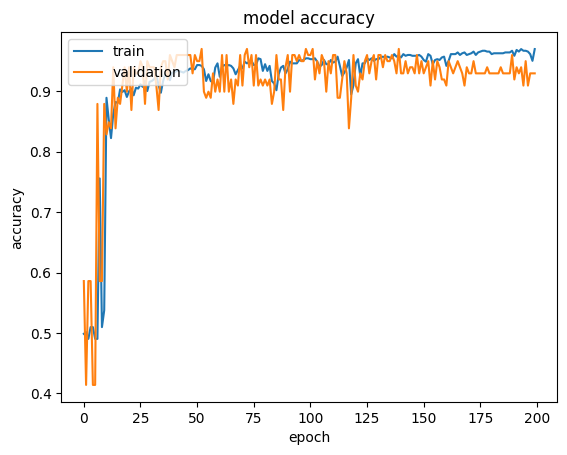

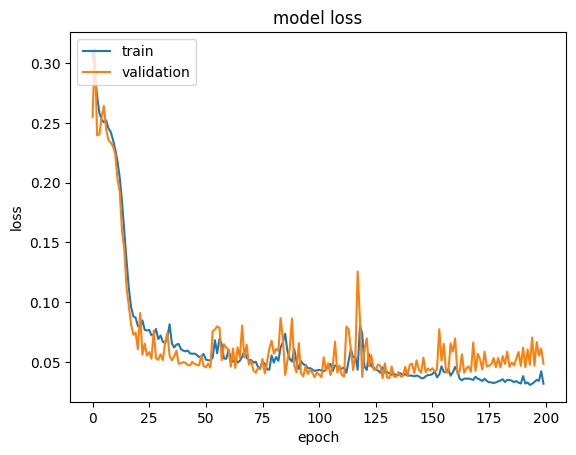

In [44]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('destination_path.eps', format='eps', dpi=1000)
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('destination_path1.eps', format='eps', dpi=1000)
plt.show()

In [45]:
model.save("fight.hdfs")